# Machine Learning Project - Bike sharing in Vancouver 
Michal Velharticky

The goal of the project: predict trip duration in seconds (inspired by the NYC taxi Kaggle challenge)

In [1]:
import numpy as np   # import numpy
import pandas as pd  # import pandas
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from sklearn.preprocessing import LabelEncoder
from geopy.geocoders import Nominatim # client for geocoding web services
import pandas as pd
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

Each month is to be joined into one file to provide same structure. The files are data is generated continually by Mobi. https://www.mobibikes.ca/en/system-data 

In [2]:
jan = pd.read_csv('Mobi_System_Data_2020-01.csv')
feb = pd.read_csv('Mobi_System_Data_2020-02.csv')
mar = pd.read_csv('Mobi_System_Data_2020-03.csv')
apr = pd.read_csv('Mobi_System_Data_2020-04.csv')
may = pd.read_csv('Mobi_System_Data_2020-05.csv')
jun = pd.read_csv('Mobi_System_Data_2020-06.csv')
jul = pd.read_csv('Mobi_System_Data_2020-07.csv')
aug = pd.read_csv('Mobi_System_Data_2020-08.csv')
sep = pd.read_csv('Mobi_System_Data_2020-09.csv')
ocb = pd.read_csv('Mobi_System_Data_2020-10.csv')
nov = pd.read_csv('Mobi_System_Data_2020-11.csv')
dec = pd.read_csv('Mobi_System_Data_2020-12.csv')

In [3]:
months = [jan,feb, mar,apr,may,jun,jul,aug,sep,ocb,nov,dec]
mobi = pd.concat(months).reset_index(drop=True)

In [4]:
mobi.head()

,Departure,Return,Bike,Departure station,Return station,Membership type,Covered distance (m),Duration (sec.),Departure battery voltage (mV),Return battery voltage (mV),Departure temperature (C),Return temperature (C),Stopover duration (sec.),Number of stopovers,Number of bike stopovers
0,2020-02-01 0:00,2020-02-01 0:00,522.0,0099 Vancouver Art Gallery - North Plaza,0196 Drake & Hornby,365 Plus,994.0,323,3881,4001,12,13,0,0.0,NaN
1,2020-02-01 0:00,2020-02-01 0:00,539.0,0126 Thurlow & Pendrell,0002 Burrard Station,30 Day Pass,1014.0,565,3697,3768,12,13,0,0.0,NaN
2,2020-02-01 0:00,2020-02-01 0:00,541.0,0244 10th & Commercial,0281 Windsor & 14th,365 Plus,1390.0,487,3682,3752,12,10,0,0.0,NaN
3,2020-02-01 0:00,2020-02-01 0:00,1234.0,0074 10th & Main,0112 10th & Oak,365 Standard,1843.0,418,3900,4005,13,15,0,0.0,NaN
4,2020-02-01 0:00,2020-02-01 0:00,2134.0,0004 Yaletown-Roundhouse Station,0011 Ontario & Seawall,365 Standard,2295.0,474,3877,4027,11,14,0,0.0,NaN


In [5]:
mobi.shape

(572166, 15)

In [6]:
mobi.keys()

Index(['Departure', 'Return', 'Bike', 'Departure station', 'Return station',
       'Membership type', 'Covered distance (m)', 'Duration (sec.)',
       'Departure battery voltage (mV)', 'Return battery voltage (mV)',
       'Departure temperature (C)', 'Return temperature (C)',
       'Stopover duration (sec.)', 'Number of stopovers',
       'Number of bike stopovers'],
      dtype='object')

In [7]:
mobi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572166 entries, 0 to 572165
Data columns (total 15 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Departure                       572166 non-null  object 
 1   Return                          572125 non-null  object 
 2   Bike                            572120 non-null  float64
 3   Departure station               572166 non-null  object 
 4   Return station                  572107 non-null  object 
 5   Membership type                 572091 non-null  object 
 6   Covered distance (m)            572166 non-null  float64
 7   Duration (sec.)                 572166 non-null  int64  
 8   Departure battery voltage (mV)  572166 non-null  int64  
 9   Return battery voltage (mV)     572166 non-null  int64  
 10  Departure temperature (C)       572166 non-null  int64  
 11  Return temperature (C)          572166 non-null  int64  
 12  Stopover duratio

In [8]:
# Check for percentage of null values as above, there are very little

nan_info = pd.DataFrame(mobi.isnull().sum()).reset_index()
nan_info.columns = ['column_name', 'nan_count']
nan_info.sort_values(by='nan_count', ascending=False, inplace=True)
nan_info['nan_percentage'] = nan_info['nan_count']/len(mobi)
nan_info

,column_name,nan_count,nan_percentage
14,Number of bike stopovers,486935,0.851038
13,Number of stopovers,85231,0.148962
5,Membership type,75,0.000131
4,Return station,59,0.000103
2,Bike,46,0.000080
1,Return,41,0.000072
0,Departure,0,0.000000
3,Departure station,0,0.000000
6,Covered distance (m),0,0.000000
7,Duration (sec.),0,0.000000


The data is fairly clean as missing values go, those I will replace with zero values for further manipulation.
Bike, Return, Missing member ship, are going to be drop, seems like an error from the system, etc. 
The number of bike stopovers gives interesting insight information that 85% are uninterrupted  without a stop. 

In [9]:
# The bellow rows to drop are categorical values and missing record cannot be replaced

mobi['Bike'] = mobi['Bike'].dropna() 
mobi['Return station'] = mobi['Return station'].dropna()
mobi['Return'] = mobi['Return'].dropna()
mobi['Membership type'] = mobi['Membership type'].dropna()

In [10]:
# Replaces the NaN with zeros

mobi['Number of bike stopovers'] = mobi['Number of bike stopovers'].fillna(value=0) 
mobi['Number of stopovers'] = mobi['Number of stopovers'].fillna(value=0) 

In [11]:
mobi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572166 entries, 0 to 572165
Data columns (total 15 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Departure                       572166 non-null  object 
 1   Return                          572125 non-null  object 
 2   Bike                            572120 non-null  float64
 3   Departure station               572166 non-null  object 
 4   Return station                  572107 non-null  object 
 5   Membership type                 572091 non-null  object 
 6   Covered distance (m)            572166 non-null  float64
 7   Duration (sec.)                 572166 non-null  int64  
 8   Departure battery voltage (mV)  572166 non-null  int64  
 9   Return battery voltage (mV)     572166 non-null  int64  
 10  Departure temperature (C)       572166 non-null  int64  
 11  Return temperature (C)          572166 non-null  int64  
 12  Stopover duratio

In [12]:
# Generation of a'trip id' for identification of a trip and other insights

mobi['Trip Id'] = mobi.index + 1000001
mobi.head(1) 

,Departure,Return,Bike,Departure station,Return station,Membership type,Covered distance (m),Duration (sec.),Departure battery voltage (mV),Return battery voltage (mV),Departure temperature (C),Return temperature (C),Stopover duration (sec.),Number of stopovers,Number of bike stopovers,Trip Id
0,2020-02-01 0:00,2020-02-01 0:00,522.0,0099 Vancouver Art Gallery - North Plaza,0196 Drake & Hornby,365 Plus,994.0,323,3881,4001,12,13,0,0.0,0.0,1000001


In [13]:
mobi['Trip Id'].nunique() 

572166

In [14]:
mobi = mobi.dropna()
mobi.isnull().sum()

Departure                         0
Return                            0
Bike                              0
Departure station                 0
Return station                    0
Membership type                   0
Covered distance (m)              0
Duration (sec.)                   0
Departure battery voltage (mV)    0
Return battery voltage (mV)       0
Departure temperature (C)         0
Return temperature (C)            0
Stopover duration (sec.)          0
Number of stopovers               0
Number of bike stopovers          0
Trip Id                           0
dtype: int64

Let's look into each column, now that our file is with no nan values

# Bike

In [94]:
print("Number of bikes in the fleet is", mobi.Bike.nunique())

Number of bikes in the fleet is 2054


The BIXI network has more than 8,000 bikes and 660 stations.

# Membership type


In [95]:
mobi['Membership type'].value_counts(normalize=True)

30 Day Pass                       0.249209
365 Standard                      0.150415
24 Hour                           0.142217
365 Plus                          0.140753
Vancity Community Pass            0.050055
365 Day Founding Plus             0.048045
365 Corporate Plus                0.046199
365 Corporate Plus Renewal        0.036149
365 Day Founding Standard         0.034706
365 Corporate Standard            0.023230
90 Day                            0.022726
365 Corporate Standard Renewal    0.017244
Single Trip Pass                  0.008118
VIP                               0.007269
365 Day Pass Plus SALE            0.006155
Archived Monthly Standard         0.005033
365 Day Pass Standard SALE        0.004745
Archived Monthly Plus             0.003563
Community Pass                    0.003127
Shared Mobility Pass              0.000988
Archived Monthly Basic            0.000031
HOPR Pass                         0.000023
Name: Membership type, dtype: float64

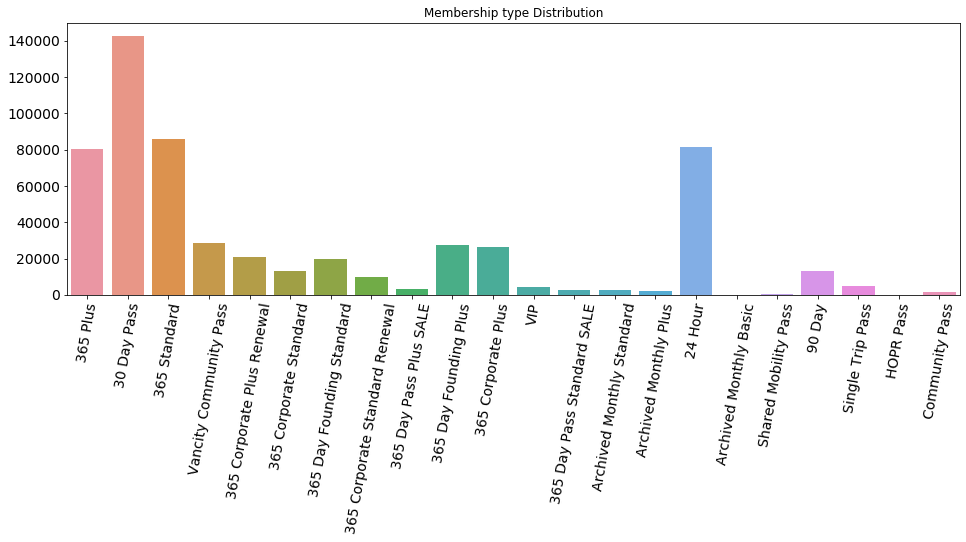

In [96]:
plt.figure(figsize=(16,5))
sns.countplot(x='Membership type', data=mobi)
plt.ylabel('')
plt.xlabel('')
plt.title('Membership type Distribution', color='black')
plt.xticks(rotation= 80,size=14)
plt.yticks(size=14)

plt.show()

I would like to recommend consideration of the availability of so many kinds of membership types. Some of the fewer favorites could be more unified in order to provide a smoother user experience. 

# Covered distance (m)


In [97]:
print("Average trip distance is", mobi['Covered distance (m)'].mean())
print("Maximum trip distance is", mobi['Covered distance (m)'].max())

Average trip distance is 2858.475309171386
Maximum trip distance is 3674220.0


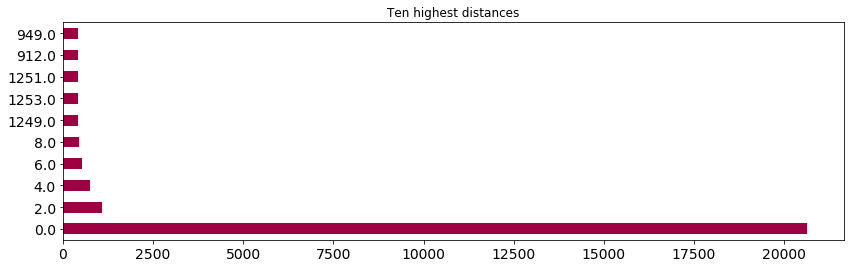

In [98]:
# Displays top ten longest trips

how_far = mobi['Covered distance (m)'].value_counts()
how_far.head(10).plot(kind='barh', title='Ten highest distances',  
                       colormap='Spectral', fontsize=14, figsize=(14,4)) 

There aren't really records of distace about 10km

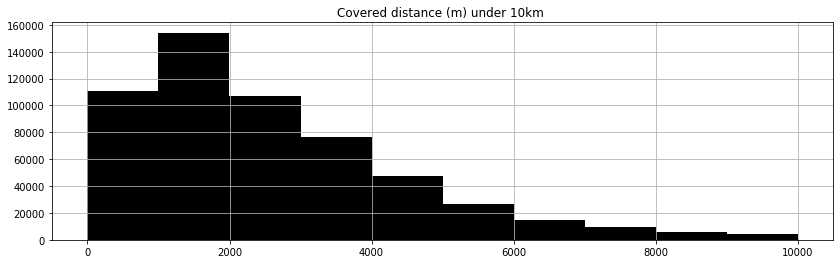

In [99]:
# Displaying trip below 10km distance

under10k = mobi[mobi['Covered distance (m)']< 10000]
hist = under10k['Covered distance (m)'].hist(bins=10, color='black', 
                figsize=(14,4)).set_title('Covered distance (m) under 10km ')

We can discard any records over 10km. The service is not used for such distances.

In [100]:
# Replaces outliers with missing Nan. 

mobi.loc[mobi['Covered distance (m)'] > 10000, 'Covered distance (m)'] = np.nan
mobi.shape

(572029, 16)

In [101]:
# Nan are filled with mean value

mobi['Covered distance (m)'] = mobi['Covered distance (m)'].fillna(mobi['Covered distance (m)'].mean())

# Duration (sec.)

In [102]:
# Conversion of seconds to minutes for a better sense of the the information

mobi['Duration (min.)'] = mobi['Duration (sec.)'] / 60

In [103]:
print("Average trip duration is", mobi['Duration (min.)'].mean(), "minutes")
print("Maximum trip duration is", mobi['Duration (min.)'].max(), "minutes")

Average trip duration is 22.9671947576086 minutes
Maximum trip duration is 34406.98333333333 minutes


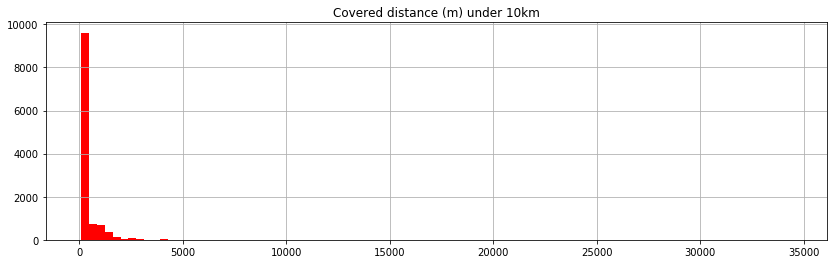

In [104]:
# Displays trips over 90 minutes in duration 

over60mins = mobi[mobi['Duration (min.)'] > 90]
hist = over60mins['Duration (min.)'].hist(bins=90, color='red', 
                figsize=(14,4)).set_title('Covered distance (m) under 10km')

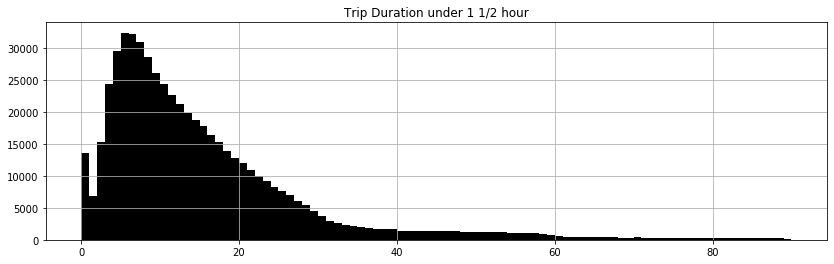

In [105]:
# Displays trips over 90 minutes in duration 

under60mins = mobi[mobi['Duration (min.)'] < 90]
hist = under60mins['Duration (min.)'].hist(bins=90, color='black', 
                figsize=(14,4)).set_title('Trip Duration under 1 1/2 hour')

Realistic values for a trip duration are kept. I think the longer trips in distance or duration are in the interests of tourists to whom daily or multiple-day rentals are a better choice. 

In [106]:
# Replaces outliers with missing Nan

mobi.loc[mobi['Duration (min.)'] > 90, 'Duration (min.)'] = np.nan
mobi.shape

(572029, 17)

In [107]:
# Nan are filled with mean value

mobi['Duration (min.)'] = mobi['Duration (min.)'].fillna(mobi['Duration (min.)'].mean())

# Stopover duration (sec.)


In [108]:
# Conversion of seconds to minutes for a better sense of the the information

mobi['Stopover duration (min.)'] = mobi['Stopover duration (sec.)'] / 60

In [109]:
print("Average trip duration is", mobi['Stopover duration (min.)'].mean(), "minutes")
print("Maximum trip duration is", mobi['Stopover duration (min.)'].max(), "minutes")

Average trip duration is 1.4298111342839896 minutes
Maximum trip duration is 30023.4 minutes


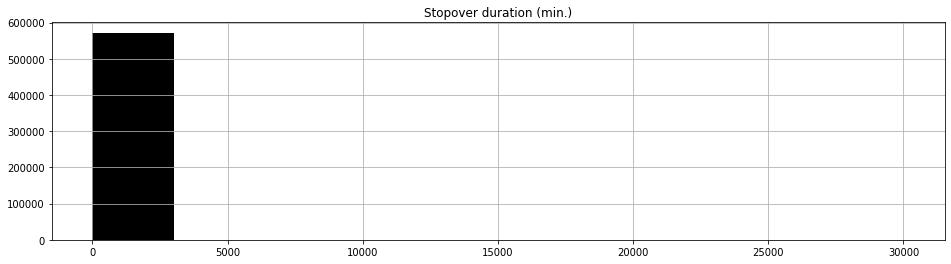

In [110]:
# Displays the distribution of Stopover duration in minutes

hist = mobi['Stopover duration (min.)'].hist(color='black', 
                figsize=(16,4)).set_title('Stopover duration (min.)') 

Let's think of a reasonable length of a stop. We need to consider that there are about 250  stations, therefore there's no reason to keep being charged for the bike.

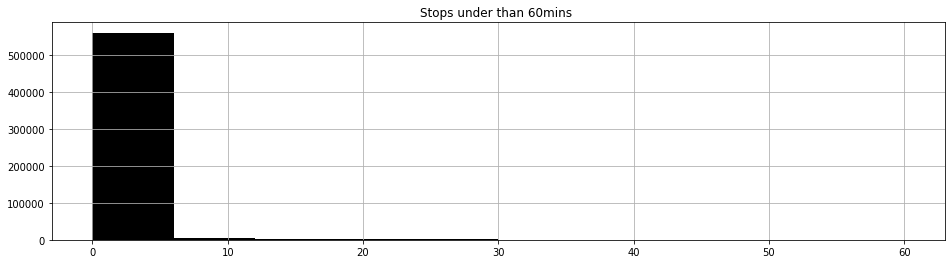

In [111]:
# Displays stopover duration in minutes uder 60mins

casual_stop = mobi[mobi['Stopover duration (min.)'] < 60]
hist = casual_stop['Stopover duration (min.)'].hist(bins=10, color='black', 
                figsize=(16,4)).set_title('Stops under than 60mins ')

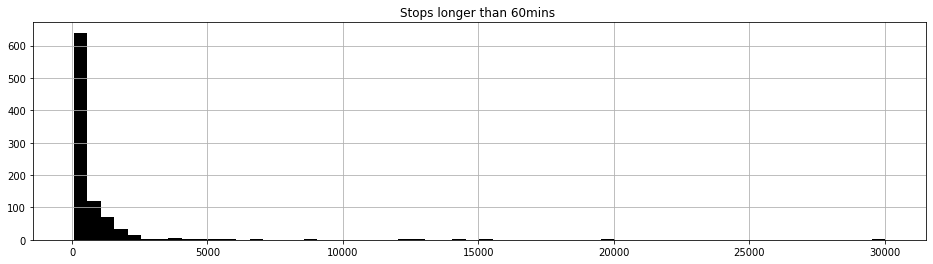

In [112]:
# Displays stopover duration in minutes over 60mins

long_stop = mobi[mobi['Stopover duration (min.)'] > 60]
hist = long_stop['Stopover duration (min.)'].hist(bins=60, color='black', 
                figsize=(16,4)).set_title('Stops longer than 60mins ')

Any trips above 60mins are removed. 

In [113]:
# Replaces outliers with missing Nan

mobi.loc[mobi['Stopover duration (min.)'] > 60, 'Stopover duration (min.)'] = np.nan
mobi.shape

(572029, 18)

In [114]:
# Droped outliers are filled with mean value

mobi['Stopover duration (min.)'] = mobi['Stopover duration (min.)'].fillna(mobi['Stopover duration (min.)'].mean())

# Number of stopovers & Number of bike stopovers 

A 'Stopover' is when a bike is locked using the cable lock rather than at a station, where a stop over is the stop using the bike terminal. 

In [115]:
mobi['Number of stopovers'].value_counts(normalize=True)

0.0     0.971671
1.0     0.020289
2.0     0.004210
3.0     0.001351
4.0     0.000846
5.0     0.000731
6.0     0.000489
7.0     0.000266
8.0     0.000091
9.0     0.000042
10.0    0.000009
14.0    0.000002
13.0    0.000002
11.0    0.000002
Name: Number of stopovers, dtype: float64

In [116]:
print("Average Number of stopovers is",mobi['Number of stopovers'].mean())
print("Maximum Number of stopovers is", mobi['Number of stopovers'].max())

Average Number of stopovers is 0.04585606673787518
Maximum Number of stopovers is 14.0


In [117]:
mobi['Number of bike stopovers'].value_counts(normalize=True)

0.0     0.994563
1.0     0.003659
2.0     0.000785
3.0     0.000336
4.0     0.000208
5.0     0.000166
6.0     0.000164
7.0     0.000066
8.0     0.000040
9.0     0.000007
13.0    0.000002
11.0    0.000002
10.0    0.000002
Name: Number of bike stopovers, dtype: float64

In [118]:
print("Average Number of bike stopovers is", mobi['Number of bike stopovers'].mean())
print("Maximum Number of bike stopovers is", mobi['Number of bike stopovers'].max())

Average Number of bike stopovers is 0.009793209784818601
Maximum Number of bike stopovers is 13.0


There's are some outliers and I will not use any records with more than 2 stopovers in both cases. We have seen, the service is used more for commute rather than sightseeing purpose.

In [119]:
# Replaces outliers with missing Nan

mobi.loc[mobi['Number of stopovers'] > 2, 'Number of stopovers'] = np.nan
mobi.loc[mobi['Number of bike stopovers'] > 2, 'Number of bike stopovers'] = np.nan

In [120]:
# Droped outliers are filled with mean value

mobi['Number of stopovers'] = mobi['Number of stopovers'].fillna(value=0)
mobi['Number of bike stopovers'] = mobi['Number of bike stopovers'].fillna(value=0)

# Departure &  Return station

In [121]:
print('The number of Departure Stations is: ',mobi['Departure station'].nunique())
print('The number of Return Stations is: ',mobi['Return station'].nunique())

The number of Departure Stations is:  225
The number of Return Stations is:  224


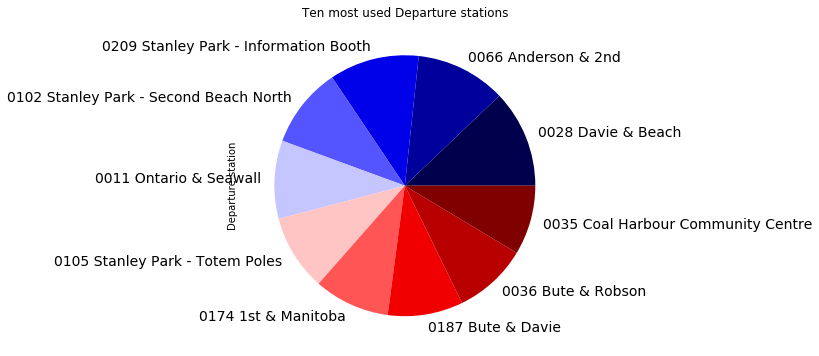

In [122]:
top_depart_stations = mobi['Departure station'].value_counts()
top_depart_stations.head(10).plot(kind='pie', title='Ten most used Departure stations', figsize=(10,6), 
                       colormap='seismic', fontsize=14) 

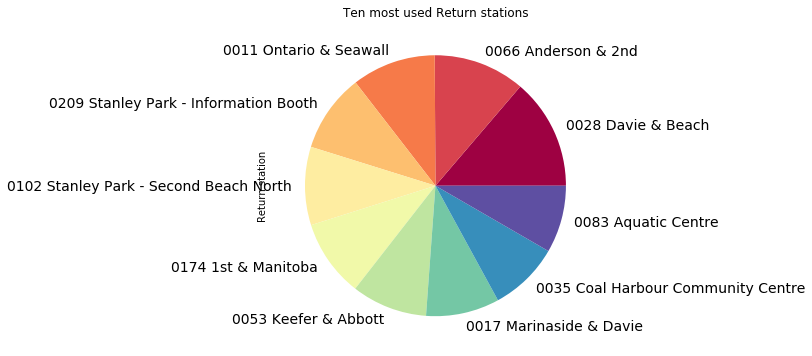

In [123]:
top_return_stations = mobi['Return station'].value_counts()
top_return_stations.head(10).plot(kind='pie', title='Ten most used Return stations', figsize=(10,6), 
                       colormap='Spectral', fontsize=14)

# Generating longitude & latidute for the machine learning purposes

In [124]:
# Creates an array of all the stations

Departure_station_name = mobi['Departure station'].unique()
Return_station_name = mobi['Return station'].unique()

In [125]:
# It is not a possible to use only the streets for the tasks of generation, 
# so complete the address ', Vancouver' is added

string = ', Vancouver'
Departure_station_name_updated = [x + string for x in Departure_station_name]
Departure_station_name_updated

['0099 Vancouver Art Gallery - North Plaza, Vancouver',
 '0126 Thurlow & Pendrell, Vancouver',
 '0244 10th & Commercial, Vancouver',
 '0074 10th & Main, Vancouver',
 '0004 Yaletown-Roundhouse Station, Vancouver',
 '0109 7th & Arbutus, Vancouver',
 '0019 Robson & Hornby, Vancouver',
 '0036 Bute & Robson, Vancouver',
 '0079 Nelson & Richards, Vancouver',
 '0134 14th & Main, Vancouver',
 '0174 1st & Manitoba, Vancouver',
 '0027 Beatty & Nelson, Vancouver',
 '0287 Carolina & Great Northern Way, Vancouver',
 '0078 Nelson & Mainland, Vancouver',
 '0070 10th & Granville, Vancouver',
 '0015 Granville & Georgia, Vancouver',
 '0037 Hornby & Nelson, Vancouver',
 '0055 Keefer & Columbia, Vancouver',
 '0063 Robson & Granville, Vancouver',
 '0191 7th & Laurel, Vancouver',
 '0080 Laurel & Broadway, Vancouver',
 '0050 Bute & Comox, Vancouver',
 '0005 Dunsmuir & Beatty, Vancouver',
 '0002 Burrard Station, Vancouver',
 '0092 Chilco & Barclay, Vancouver',
 '0107 8th & Ontario, Vancouver',
 '0021 Cordova 

In [126]:
string = ', Vancouver'
Return_station_name_uptaded = [str(x) + string for x in Return_station_name]
Return_station_name_uptaded

['0196 Drake & Hornby, Vancouver',
 '0002 Burrard Station, Vancouver',
 '0281 Windsor & 14th, Vancouver',
 '0112 10th & Oak, Vancouver',
 '0011 Ontario & Seawall, Vancouver',
 '0065 Cypress & Cornwall, Vancouver',
 '0280 Triumph & Victoria, Vancouver',
 '0019 Robson & Hornby, Vancouver',
 '0004 Yaletown-Roundhouse Station, Vancouver',
 '0005 Dunsmuir & Beatty, Vancouver',
 '0177 Quebec & 1st, Vancouver',
 '0001 10th & Cambie, Vancouver',
 '0191 7th & Laurel, Vancouver',
 '0140 Burrard & 7th, Vancouver',
 '0058 Homer & Smithe, Vancouver',
 '0134 14th & Main, Vancouver',
 '0211 14th & Alder, Vancouver',
 '0078 Nelson & Mainland, Vancouver',
 '0040 Cardero & Pendrell, Vancouver',
 '0088 Harwood & Bute, Vancouver',
 '0069 7th & Granville, Vancouver',
 '0174 1st & Manitoba, Vancouver',
 '0032 Comox & Denman, Vancouver',
 '0064 Expo & Smithe, Vancouver',
 '0187 Bute & Davie, Vancouver',
 '0092 Chilco & Barclay, Vancouver',
 '0165 Columbia & 4th, Vancouver',
 '0030 Abbott & Cordova, Vancouver

In [127]:
# Dictionary is created taking the previous address and the updated address
# in order to replace the list of addresses 
# '0196 Drake & Hornby': '0196 Drake & Hornby, Vancouver'

departure_station_dictionary  = dict(zip(Departure_station_name, Departure_station_name_updated))
return_station_dictionary = dict(zip(Return_station_name, Return_station_name_uptaded))

In [128]:
# Applying the dictionaries

mobi['Departure station'] = mobi['Departure station'].replace(departure_station_dictionary)
mobi['Return station'] = mobi['Return station'].replace(return_station_dictionary)

In [129]:
mobi['Departure station'].head(1)

0    0099 Vancouver Art Gallery - North Plaza, Vanc...
Name: Departure station, dtype: object

In [130]:
# During the generation there were several addresses that needed a correction 
# for example: "TEMP REMOVED", "¬†Scotia", etc. 

location_name_correction = {
        '0174 1st & Manitoba, Vancouver':'88w W 1st Ave, Vancouver',
        '0037 Hornby & Nelson, Vancouver':'991 Hornby St, Vancouver',
        '0981 Workshop - Service Complete, Vancouver':'0981 Workshop, Vancouver',
        '0154 Kitsilano Beach, Vancouver':'0154 Kitsilano, Vancouver',
        '0197 1st &¬†Scotia, Vancouver':'0197 1st & Main, Vancouver',
        '0282 14th & Fraser, Vancouver':'2120 Fir St, Vancouver',
        '0228 Keefer & Hawks, Vancouver':'799 Keefer St, Vancouver',
        '0980 Workshop - Balancer Bike Check In, Vancouver':'0980 Workshop, Vancouver',
        '0129 Richards & Robson - TEMP REMOVED, Vancouver':'0129 Richards & Robson, Vancouver',
        '0982 Workshop - Bike Testing, Vancouver':'0982 Workshop, Vancouver',
        '0991 HQ Workshop, Vancouver':'0991 Workshop, Vancouver',
        '0082 Richards & Davie - TEMP REMOVED, Vancouver':'0082 Richards & Davie, Vancouver',
        '0058 Homer & Smithe - TEMP REMOVED, Vancouver':'0058 Homer & Smithe, Vancouver',
        '0985 Yard - Long Term Storage, Vancouver':'0985 Yard, Vancouver',
        '0165 Columbia & 4th - TEMP REMOVED, Vancouver':'0165 Columbia & 4th, Vancouver',
        '0986 Quebec Yard - Serviced, Vancouver':'0986 Quebec Yard, Vancouver',
        '0985 Quebec Yard - To Service, Vancouver':'0985 Quebec Yard, Vancouver',
        '0995 Workshop - On Deck, Vancouver':'0995 Workshop, Vancouver',
        '0196 Drake & Hornby, Vancouver':'0196 Drake, Vancouver',
        '0060 Bidwell & Burnaby, Vancouver':'1264 Bidwell St, Vancouver',
        '0153 Arbutus Greenway & Fir, Vancouver':'0153 Arbutus Greenway, Vancouver',
        '9999 Smoove_atelier, Vancouver':'453 West 12th Ave, Vancouver',
        '0197 1st &Â\xa0Scotia, Vancouver':'0197 1st & Main, Vancouver',
        '0002 Burrard Station (Melville & Dunsmuir), Vancouver':'0002 Burrard Station, Vancouver',
        '0025 Homer & Robson (Vancouver Public Library), Vancouver':'0025 Homer & Robson, Vancouver',
        '0278 15th & Victoria (Trout Lake), Vancouver':'0278 15th & Victoria, Vancouver',
        '0007 12th & Yukon (City Hall), Vancouver':'0007 12th & Yukon, Vancouver',
        '0227 Campbell & Hastings - TEMP REMOVED, Vancouver':'0227 Campbell & Hastings, Vancouver',
        '0211 14th & Alder - TEMP REMOVED, Vancouver':'0211 14th & Alder, Vancouver',
        '0154 Kitsilano Beach Park, Vancouver':'0154 Kitsilano Park, Vancouver'
}

mobi['Departure station'] = mobi['Departure station'].replace(location_name_correction)
mobi['Return station'] = mobi['Return station'].replace(location_name_correction)

In [131]:
# There are about 250 stations but 500k rows, the generations of longitude and latidute 
# would take a very longtime, therefore it would be applied with a dictrionary. 
# Address matching with longitude and latidute. 

departure_array = mobi['Departure station'].unique()
return_array = mobi['Return station'].unique()

In [132]:
# Creates a small dataframe for more effective generation 
# the generation of longitude and latidute 

departureName_df = pd.DataFrame({'Departure name': departure_array})
departureName_df.head(1)

,Departure name
0,"0099 Vancouver Art Gallery - North Plaza, Vanc..."


In [133]:
returnName_df = pd.DataFrame({'Return name': return_array})
returnName_df.head(1)

,Return name
0,"0196 Drake, Vancouver"


In [134]:
geolocator = Nominatim(user_agent='https://www.google.ca/maps?source=tldsi&hl=cs')
departureName_df['Departure lat&long'] = departureName_df['Departure name'].apply(geolocator.geocode, timeout=2).apply(lambda x: (x.latitude, x.longitude))

In [135]:
# Updated of the Departure lat&long with '' for the dictionary

departureName_df.update("'" + departureName_df[['Departure lat&long']].astype(str)+"'")
departureName_df.head(1)

,Departure name,Departure lat&long
0,"0099 Vancouver Art Gallery - North Plaza, Vanc...","'(49.2831979, -123.1204825)'"


In [136]:
geolocator = Nominatim(user_agent='https://www.google.ca/maps?source=tldsi&hl=cs')
returnName_df['Return lat&long'] = returnName_df['Return name'].apply(geolocator.geocode, timeout=3).apply(lambda x: (x.latitude, x.longitude))

In [137]:
returnName_df.update("'" + returnName_df[['Return lat&long']].astype(str)+"'")
returnName_df.head(1)

,Return name,Return lat&long
0,"0196 Drake, Vancouver","'(49.2753898, -123.1267317)'"


In [138]:
return_name_array= returnName_df['Return name'].unique()
return_lat_long_array = returnName_df['Return lat&long'].unique()

return_station_dictionary = dict(zip(return_name_array, return_lat_long_array))

In [139]:
depart_name_array = departureName_df['Departure name'].unique()
depart_lat_long_array = departureName_df['Departure lat&long'].unique()

departure_station_dictionary = dict(zip(depart_name_array, depart_lat_long_array))

In [140]:
mobi['Departure station Lat & Long'] = mobi['Departure station']
mobi['Return station Lat & Long']= mobi['Return station']

In [141]:
return_station_dictionary

{'0196 Drake, Vancouver': "'(49.2753898, -123.1267317)'",
 '0002 Burrard Station, Vancouver': "'(49.2856364, -123.1198152)'",
 '0281 Windsor & 14th, Vancouver': "'(49.2580237, -123.0833488)'",
 '0112 10th & Oak, Vancouver': "'(49.2622734, -123.12616)'",
 '0011 Ontario & Seawall, Vancouver': "'(49.2716914, -123.1042968)'",
 '0065 Cypress & Cornwall, Vancouver': "'(49.2727532, -123.1477204)'",
 '0280 Triumph & Victoria, Vancouver': "'(49.2839768, -123.0652119)'",
 '0019 Robson & Hornby, Vancouver': "'(49.2827328, -123.1220614)'",
 '0004 Yaletown-Roundhouse Station, Vancouver': "'(49.2745376, -123.121905)'",
 '0005 Dunsmuir & Beatty, Vancouver': "'(49.2797102, -123.1100831)'",
 '0177 Quebec & 1st, Vancouver': "'(49.2703309, -123.1027341)'",
 '0001 10th & Cambie, Vancouver': "'(49.2625027, -123.1144027)'",
 '0191 7th & Laurel, Vancouver': "'(49.2650434, -123.1237691)'",
 '0140 Burrard & 7th, Vancouver': "'(49.2653522, -123.1457925)'",
 '0058 Homer & Smithe, Vancouver': "'(49.2782142, -123.

In [142]:
departure_station_dictionary

{'0099 Vancouver Art Gallery - North Plaza, Vancouver': "'(49.2831979, -123.1204825)'",
 '0126 Thurlow & Pendrell, Vancouver': "'(49.2808952, -123.130541)'",
 '0244 10th & Commercial, Vancouver': "'(49.261412, -123.0701593)'",
 '0074 10th & Main, Vancouver': "'(49.2620812, -123.1018465)'",
 '0004 Yaletown-Roundhouse Station, Vancouver': "'(49.2745376, -123.121905)'",
 '0109 7th & Arbutus, Vancouver': "'(49.2656102, -123.1525342)'",
 '0019 Robson & Hornby, Vancouver': "'(49.2827328, -123.1220614)'",
 '0036 Bute & Robson, Vancouver': "'(49.2858689, -123.1272595)'",
 '0079 Nelson & Richards, Vancouver': "'(49.2777729, -123.1208527)'",
 '0134 14th & Main, Vancouver': "'(49.2583876, -123.1007426)'",
 '88w W 1st Ave, Vancouver': "'(49.2712646, -123.1815532)'",
 '0027 Beatty & Nelson, Vancouver': "'(49.275649, -123.1170024)'",
 '0287 Carolina & Great Northern Way, Vancouver': "'(49.2673905, -123.0907632)'",
 '0078 Nelson & Mainland, Vancouver': "'(49.2765028, -123.1189009)'",
 '0070 10th & Gr

In [143]:
mobi['Departure station Lat & Long']= mobi['Departure station Lat & Long'].replace(departure_station_dictionary)
mobi['Departure station Lat & Long']= mobi['Departure station Lat & Long'].str.strip("''")
mobi['Departure station Lat & Long'].head(1)

0    (49.2831979, -123.1204825)
Name: Departure station Lat & Long, dtype: object

In [144]:
mobi['Return station Lat & Long'] = mobi['Return station Lat & Long'].replace(return_station_dictionary)
mobi['Return station Lat & Long']= mobi['Return station Lat & Long'].str.strip("''")
mobi['Return station Lat & Long'].head(1)

0    (49.2753898, -123.1267317)
Name: Return station Lat & Long, dtype: object

In [145]:
mobi['Departure Latitude'], mobi['Departure Longitude']= mobi['Departure station Lat & Long'].str.split(',',1).str
mobi['Return Latitude'], mobi['Return Longitude']= mobi['Return station Lat & Long'].str.split(',',1).str

In [146]:
mobi['Departure Latitude'] = mobi['Departure Latitude'].str.strip('(')
mobi['Departure Longitude'] = mobi['Departure Longitude'].str.strip(')')

mobi['Return Latitude']= mobi['Return Latitude'].str.strip('(')
mobi['Return Longitude']= mobi['Return Longitude'].str.strip(')')

In [147]:
mobi= mobi.drop(['Departure station Lat & Long','Return station Lat & Long'],axis=1)

In [148]:
mobi.keys()

Index(['Departure', 'Return', 'Bike', 'Departure station', 'Return station',
       'Membership type', 'Covered distance (m)', 'Duration (sec.)',
       'Departure battery voltage (mV)', 'Return battery voltage (mV)',
       'Departure temperature (C)', 'Return temperature (C)',
       'Stopover duration (sec.)', 'Number of stopovers',
       'Number of bike stopovers', 'Trip Id', 'Duration (min.)',
       'Stopover duration (min.)', 'Departure Latitude', 'Departure Longitude',
       'Return Latitude', 'Return Longitude'],
      dtype='object')

In [149]:
mobi= mobi.drop(['Departure station','Return station','Covered distance (m)',
                'Duration (min.)'], axis=1)

In [150]:
all_columns = mobi.keys()
mobi_geo = pd.DataFrame(mobi, columns=all_columns)

mobi_geo.to_csv('mobi_geo.csv', index=False)

In [191]:
mobi_geo = pd.read_csv('mobi_geo.csv')
mobi_geo.head(1)

,Departure,Return,Bike,Membership type,Duration (sec.),Departure battery voltage (mV),Return battery voltage (mV),Departure temperature (C),Return temperature (C),Stopover duration (sec.),Number of stopovers,Number of bike stopovers,Trip Id,Stopover duration (min.),Departure Latitude,Departure Longitude,Return Latitude,Return Longitude
0,2020-02-01 0:00,2020-02-01 0:00,522.0,365 Plus,323,3881,4001,12,13,0,0.0,0.0,1000001,0.0,49.2832,-123.12,49.2754,-123.127


In [192]:
mobi_geo['Departure Latitude'] = pd.to_numeric(mobi_geo['Departure Latitude'],errors='coerce')
mobi_geo['Departure Longitude']= pd.to_numeric(mobi_geo['Departure Longitude'],errors='coerce')

mobi_geo['Return Latitude']=pd.to_numeric(mobi_geo['Return Latitude'],errors='coerce')
mobi_geo['Return Longitude']=pd.to_numeric(mobi_geo['Return Longitude'],errors='coerce')

In [193]:
mobi_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572029 entries, 0 to 572028
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Departure                       572029 non-null  object 
 1   Return                          572029 non-null  object 
 2   Bike                            572029 non-null  float64
 3   Membership type                 572029 non-null  object 
 4   Duration (sec.)                 572029 non-null  int64  
 5   Departure battery voltage (mV)  572029 non-null  int64  
 6   Return battery voltage (mV)     572029 non-null  int64  
 7   Departure temperature (C)       572029 non-null  int64  
 8   Return temperature (C)          572029 non-null  int64  
 9   Stopover duration (sec.)        572029 non-null  int64  
 10  Number of stopovers             572029 non-null  float64
 11  Number of bike stopovers        572029 non-null  float64
 12  Trip Id         

FEATURES:

In [194]:
mobi_geo['Departure'] = pd.to_datetime(mobi_geo['Departure'])

In [195]:
mobi_geo['Departure Day of Week'] = mobi_geo.Departure.dt.dayofweek
mobi_geo['Departure Day of Month'] = mobi_geo.Departure.dt.day
mobi_geo['Departure Day of Year'] = mobi_geo.Departure.dt.dayofyear
mobi_geo['Departure Month'] = mobi_geo.Departure.dt.month
mobi_geo['Departure Year'] = mobi_geo.Departure.dt.year

Working day & weekend

In [196]:
work_day_or_not = [1,0] #1 -> working day
cut_bins= [-1,5,6]
mobi_geo['Working Day'] = pd.cut(mobi_geo['Departure Day of Week'], bins=cut_bins, labels=work_day_or_not)
mobi_geo['Working Day'].value_counts(normalize=True)

1    0.860927
0    0.139073
Name: Working Day, dtype: float64

In [197]:
mobi_geo['Working Day'] = mobi_geo['Working Day'].astype(int)

The insight here is, 86% of bike uses happen during the week, which makes them clear 
'to work or school' commutes.

Seasons of the year

In [198]:
bins = [0, 91, 183, 275, 366]
labels=['4', '1', '2', '3']  #'Winter'=4, 'Spring'=1, 'Summer'=2, 'Fall=3'

mobi_geo['Season'] = pd.cut(mobi_geo['Departure Day of Year'] + 11 - 366*(mobi_geo['Departure Day of Year'] > 355), 
                        bins=bins, labels=labels)
print('Distribution of bike service usage')
mobi_geo['Season'].value_counts(normalize=True)

Distribution of bike service usage


2    0.415519
1    0.213877
3    0.192226
4    0.178377
Name: Season, dtype: float64

Text(0.5, 1.0, 'Spring=1, Summer=2, Fall=3, Winter=4,')

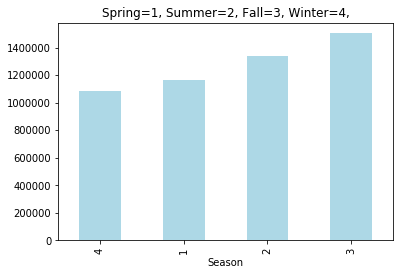

In [199]:
mobi_geo.groupby('Season')['Trip Id'].mean().plot.bar(color='lightblue').set_title("Spring=1, Summer=2, Fall=3, Winter=4,")

In [200]:
mobi_geo.keys()

Index(['Departure', 'Return', 'Bike', 'Membership type', 'Duration (sec.)',
       'Departure battery voltage (mV)', 'Return battery voltage (mV)',
       'Departure temperature (C)', 'Return temperature (C)',
       'Stopover duration (sec.)', 'Number of stopovers',
       'Number of bike stopovers', 'Trip Id', 'Stopover duration (min.)',
       'Departure Latitude', 'Departure Longitude', 'Return Latitude',
       'Return Longitude', 'Departure Day of Week', 'Departure Day of Month',
       'Departure Day of Year', 'Departure Month', 'Departure Year',
       'Working Day', 'Season'],
      dtype='object')

In [201]:
mobi_geo['Season'] = mobi_geo['Season'].astype(int)

In [202]:
mobi_geo = mobi_geo.drop(['Departure','Return'], axis=1)

# Data preprocessing and encoding

In [203]:
mobi_geo.dtypes.unique() # check all unique dtypes

array([dtype('float64'), dtype('O'), dtype('int64')], dtype=object)

In [204]:
cat_features = [f for f in mobi_geo.columns if mobi_geo[f].dtype not in ['int64','float64']]
cat_features

['Membership type']

In [205]:
nan_info = pd.DataFrame(mobi_geo[cat_features].isnull().sum()).reset_index() # get columns which has NAN
nan_info.columns = ['column','cnt_nan']
nan_info.sort_values('cnt_nan',ascending=False,inplace=True)
nan_info

,column,cnt_nan
0,Membership type,0


In [206]:

mobi_geo['Membership type'] = LabelEncoder().fit_transform(mobi_geo['Membership type'])

In [207]:
num_features = [f for f in mobi_geo.columns if (f not in cat_features) and f not in ['Trip Id','Duration (sec.)']]
num_features

['Bike',
 'Departure battery voltage (mV)',
 'Return battery voltage (mV)',
 'Departure temperature (C)',
 'Return temperature (C)',
 'Stopover duration (sec.)',
 'Number of stopovers',
 'Number of bike stopovers',
 'Stopover duration (min.)',
 'Departure Latitude',
 'Departure Longitude',
 'Return Latitude',
 'Return Longitude',
 'Departure Day of Week',
 'Departure Day of Month',
 'Departure Day of Year',
 'Departure Month',
 'Departure Year',
 'Working Day',
 'Season']

In [208]:
nan_info = pd.DataFrame(mobi_geo[num_features].isnull().sum()).reset_index() # get nan info for numerical features
nan_info.columns = ['column','cnt_nan']
nan_info.sort_values('cnt_nan',ascending=False,inplace=True)
nan_info

,column,cnt_nan
11,Return Latitude,2970
12,Return Longitude,2970
10,Departure Longitude,2630
9,Departure Latitude,2630
18,Working Day,0
17,Departure Year,0
16,Departure Month,0
15,Departure Day of Year,0
14,Departure Day of Month,0
13,Departure Day of Week,0


In [209]:
cols = nan_info.loc[nan_info.cnt_nan>0]['column'].values
cols

array(['Return Latitude', 'Return Longitude', 'Departure Longitude',
       'Departure Latitude'], dtype=object)

In [210]:
for f in cols:
    mobi_geo[f] = mobi_geo[f].fillna(mobi_geo[f].mean())

In [211]:
mobi_geo.isnull().sum().sum() ### no missing values any more

0

# Model Training

In [212]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [213]:
# get X and y, X input, y target

features = [f for f in mobi_geo.columns if f not in ['Trip Id','Duration (sec.)']]
X = mobi_geo[features]
y = mobi_geo['Duration (sec.)']
X.shape,len(y)

((572029, 21), 572029)

In [214]:
#split out for some validation, using train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=4, test_size=0.2)

#X_train,X_valid, y_train,y_valid = train_test_split(X,y,shuffle=True,random_state=10, test_size=0.25)
print(X_train.shape,X_valid.shape,len(y_train),len(y_test))

(457623, 21) (143008, 14) 457623 114406


In [215]:
X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

Linear regressor for the raw data

In [216]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

In [217]:
#Linear regressor for the raw data
regressor = LinearRegression() 
regressor.fit(X_train,y_train) 

LinearRegression()

In [218]:
#Predict from the test features of raw data
y_pred = regressor.predict(X_test)  

In [219]:
#Evaluate the regressor on the raw data
print('RMSE score for the Multiple LR raw is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred))))
print('Variance score for the Multiple LR raw is : %.2f' % regressor.score(X_test, y_test))
print("\n")

RMSE score for the Multiple LR raw is : 5994.579460903852
Variance score for the Multiple LR raw is : 0.52




Random Forest Regressor

In [220]:
regressor_rf = RandomForestRegressor(n_jobs=-1)

In [221]:
regressor_rf.fit(X_train,y_train)



RandomForestRegressor(n_jobs=-1)

In [222]:

y_pred = regressor_rf.predict(X_test)


In [223]:
print('RMSE score for the RF regressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred))))
print('RMSLE score for the RF regressor is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test,y_pred))))
print('Variance score for the RF regressor is : %.2f' % regressor_rf.score(X_test, y_test))

RMSE score for the RF regressor is : 6697.545511648032
RMSLE score for the RF regressor is : 0.9418582272688056
Variance score for the RF regressor is : 0.40


XGBoost regressor

In [224]:
regressor_xgb = XGBRegressor(n_estimators=300,
                            learning_rate=0.08,
                            gamma=0,
                            subsample=0.75,
                            colsample_bytree=1,
                            max_depth=7,
                            min_child_weight=4,
                            silent=1,
                           n_jobs=-1)

In [225]:
regressor_xgb.fit(X_train,y_train)


XGBRegressor(learning_rate=0.08, max_depth=7, min_child_weight=4,
             n_estimators=300, n_jobs=-1, silent=1, subsample=0.75)

In [226]:
y_pred = regressor_xgb.predict(X_test)


In [227]:
print('RMSE score for the XGBoost regressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred))))
print('Variance score for the XGBoost regressor is : %.2f' % regressor_xgb.score(X_test, y_test))

RMSE score for the XGBoost regressor is : 6517.113594144167
Variance score for the XGBoost regressor is : 0.44


Decision tree for feature importance on a classification problem

In [228]:
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot

In [240]:
# Dataseet definition 

X, y = make_classification(n_samples=1000, n_features=20, n_informative=5, random_state=1)

In [241]:
# Model definition

model = DecisionTreeClassifier()

In [242]:
# Model fitting

model.fit(X, y)

DecisionTreeClassifier()

In [243]:
# get importance
importance = model.feature_importances_

In [244]:
# Feature importance summary 
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.33721
Feature: 1, Score: 0.01205
Feature: 2, Score: 0.08897
Feature: 3, Score: 0.00809
Feature: 4, Score: 0.01058
Feature: 5, Score: 0.01753
Feature: 6, Score: 0.01238
Feature: 7, Score: 0.03727
Feature: 8, Score: 0.01452
Feature: 9, Score: 0.02219
Feature: 10, Score: 0.01071
Feature: 11, Score: 0.01451
Feature: 12, Score: 0.02060
Feature: 13, Score: 0.01295
Feature: 14, Score: 0.08178
Feature: 15, Score: 0.01172
Feature: 16, Score: 0.03713
Feature: 17, Score: 0.20072
Feature: 18, Score: 0.04708
Feature: 19, Score: 0.00200


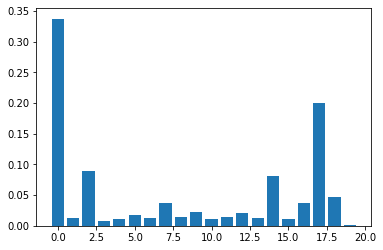

In [245]:
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()